In [1]:
from datasets import load_dataset
from tqdm import tqdm
from datasets import Dataset
import torch 
import matplotlib.pyplot as plt 
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from sklearn.model_selection import train_test_split
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
import tqdm
from tqdm import trange, tqdm
import numpy as np
from sklearn.metrics import accuracy_score
import pandas as pd
from sklearn.metrics import multilabel_confusion_matrix
import os 
import seaborn as sns

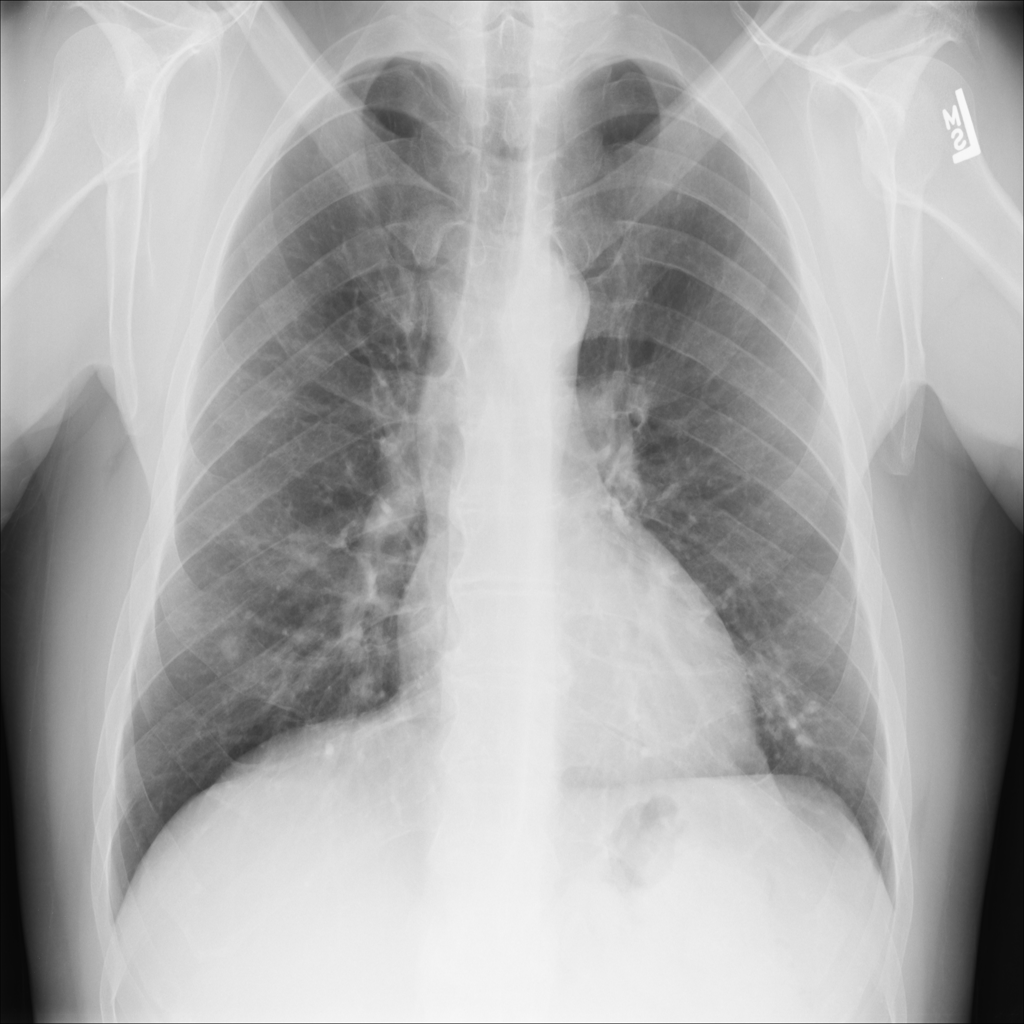

In [2]:


#If you haven't downloaded already, this takes aroun  40GB and around half an hour to download all the data (note that we split here)
# it will be cached on your system, so you access it in the future by running this code (rather than opening the files per se)
# once you've downloaded, hugging face automatically checks to see if you've already downloaded so subsequent loads are quick 

# we use just a small portion here to get our code working 
# hugging face has already split in to train and test so we can use train here and make a validation subset in our custom dataset class 
ds_train = load_dataset("alkzar90/NIH-Chest-X-ray-dataset", 'image-classification', split = "train[:500]") 

# we hold back our test data to be used purely for testing, not in the context of our training loop 
ds_test = load_dataset("alkzar90/NIH-Chest-X-ray-dataset", 'image-classification', split = "test[:500]") 

# you can view a single image to check things have worked 
ds_train[300]['image']





In [8]:
for i in tqdm(range(4)):
    print(i)

100%|██████████| 4/4 [00:00<00:00, 46863.73it/s]

0
1
2
3


In [3]:
def extract_patches(image_tensor, patch_size = 4):
    bs, c, h, w = image_tensor.size()

    # define teh unfold layer with appropriate parameters 

    unfold = torch.nn.Unfold(kernel_size = patch_size, stride = patch_size)

    unfolded = unfold(image_tensor)

    # reshape the unfolded tensor to match the desired output shape 
    # output shaep BS x L x C x 8 x8 where L is the number of patches in each dimension 
    # fo reach dimension, number of patches = (original dimension size) //patch_size 

    unfolded = unfolded.transpose(1, 2).reshape(bs, -1, c * patch_size * patch_size)

    return unfolded


# we have a hugging face dataset, so we now define a custom dataset class which processes this, ensures our labels are one hot encoded etc. 

class MultiLabelDataset(Dataset):
    """
    Initialize with a Hugging Face dataset that's already formatted as torch tensors. 
    Will convert to tensors if plain hugging face dataset. 
    Will handle the multi label nature of our data through one hot encoding 
    
    Args:
        hf_dataset: A Hugging Face dataset with 'image' and 'labels' columns
    """
      
    def __init__(self, hf_dataset, image_size):

        self.x_train, self.x_val, self.y_train, self.y_val = None, None, None, None
        self.mode = "train"

        hf_dataset = hf_dataset.with_format("torch")
        print(hf_dataset.format)

        self.processed_images = []
        self.processed_labels = []

        for sample in tqdm(hf_dataset, desc = "processing images", leave= True):
            image = sample['image']

            # we resize our image if specified 
            
            image = F.interpolate(image.unsqueeze(0), size = image_size, mode = "bilinear").squeeze(0)


            if image.shape[0] == 4:
                image = torch.index_select(image, 0, torch.tensor([0]))

            # normalize pixel values 
            image = image/255

            if image.shape[0] == 1:
                image = image.repeat(3, 1, 1) # for convolutional networks we need 3 channels, remove this line and line below if wanting 1024, 1024 shape 

            # image = image.permute(1, 2, 0) # channel dimension needs to be the last one, not first 

            labels = sample['labels']
            one_hot = torch.zeros(15, dtype = torch.long)
            one_hot[labels] = 1
            self.processed_images.append(image)
            self.processed_labels.append(one_hot)
    
    def train_validation_split(self):
        """
        Takes our training data and produces a validation set from our training data
        Ensures that we don't use our hugging face defined test set during the training process 
        Means that we will assess trained models on a totally separate test set to avoid overfitting on test set
        Note that we use a subset of train as a validation set 
        """
        self.x_train, self.x_val, self.y_train, self.y_val = train_test_split(self.processed_images, self.processed_labels, test_size = 0.2,
                                                                              random_state = 42)
        

    def __len__(self):
        """ Returns the length of our training or validation set depending on mode """
        if self.mode == "train":
            return len(self.x_train)
        elif self.mode == "val":
            return len(self.x_val)
        elif self.mode == "test":
            return len(self.processed_images)
    
        

    # note we are not doing lazy processing, so our data is processed when the dataset is instantiated. 
    # here we will return a train test split of our hugging face training data, unless we're using the test data in which case we return it all 
    def __getitem__(self, idx):
        """Gets items from either the training or validation set depending on mode"""
        if self.mode == "train":
            return {"image": self.x_train[idx], "labels": self.y_train[idx]}
        elif self.mode == "val":
            return {"image": self.x_val[idx], "labels": self.y_val[idx]}
        elif self.mode == "test":
            return {"image": self.processed_images[idx], "labels": self.processed_labels[idx]}
    
        



# we create patches 
# we embed these patches by using encoder only transformer 
# then we pass them through an encoder only transformer 
# use a transformer - self attention mixes spatial regions of an image earlier on (rather than convolutions which takes time to get entire spatial field of image)
# by treating every pixel as an embedding in a sequence, each spatial region can query all other spatial regions in image - gives context 

# neeed to start by writing a transformer block class with self attention 

class TransformerBlock(nn.Module):
    def __init__(self, hidden_size = 128, num_heads = 4):
        super(TransformerBlock, self).__init__()


        # layer normalisation to normalize the input data 
        self.norm1 = nn.LayerNorm(hidden_size)


        # multi head attention mechanism 

        self.multihead_attn = nn.MultiheadAttention(hidden_size, num_heads=num_heads, 
                                                    batch_first = True, dropout = 0.1)
        
        # another layer of normalisation 

        self.norm2 = nn.LayerNorm(hidden_size)

        # multi layer perceptron with a hidden layer and activation function 

        self.mlp = nn.Sequential(
            nn.Linear(hidden_size, hidden_size *2), 
            nn.LayerNorm(hidden_size * 2),
            nn.ELU(), 
            nn.Linear(hidden_size * 2, hidden_size))
        
    def forward(self, x):

        # apply the first layer of normalisation 

        norm_x = self.norm1(x)

        # apply multi headed attention and add the input (residual connection)

        x = self.multihead_attn(norm_x, norm_x, norm_x)[0] + x

        # apply second layer of normalisation 

        norm_x = self.norm2(x)

        # pass through the mlp and add the input (Residual connection)

        x = self.mlp(norm_x) + x

        return x 
        

class ViT(nn.Module):
    def __init__(self, image_size, channels_in, patch_size, hidden_size,
                 num_layers, num_heads = 8):
        super(ViT, self).__init__()

        self.patch_size = patch_size

        # fully connected layer to project input patches to the hidden size dimension 

        self.fc_in = nn.Linear(channels_in * patch_size * patch_size, hidden_size) # this is causing a problem atm 

        # create list of transformer blocks 

        self.blocks = nn.ModuleList([
            TransformerBlock(hidden_size, num_heads) for _ in range(num_layers)])
        
        # fully connected output layer to map to the number of classes 

        self.fc_out = nn.Linear(hidden_size, 15)

        # parameter for the output token 

        self.out_vec = nn.Parameter(torch.zeros(1, 1, hidden_size))

        # positional embeddings to retain positional information of patches 

        seq_length = (image_size //patch_size) **2
        self.pos_embedding = nn.Parameter(torch.empty(1, seq_length, hidden_size).normal_(std = 0.001))

    def forward(self, image):

        bs = image.shape[0]

        # extract patches from the image and flatten them 

        patch_seq = extract_patches(image, patch_size = self.patch_size)

        

        # project patches to the hidden size dimension 

        patch_emb = self.fc_in(patch_seq)


        # add positional embeddings to the patch embeddings 

        patch_emb = patch_emb + self.pos_embedding

        # concatenate the output token to the patch embeddings 

        embs = torch.cat((self.out_vec.expand(bs, 1, -1), patch_emb), 1)

        # pass embeddings through each transformer block 

        for block in self.blocks: 
            embs = block(embs)

        return self.fc_out(embs[:, 0])



In [4]:
# now we can produce our train and validation dataloaders which will be used in training later
training_dataset_class = MultiLabelDataset(ds_train, image_size = (128, 128)) # make sure to have the channel dimension
training_dataset_class.train_validation_split()

# set dataset class mode to train to generate a training split 
training_dataset_class.mode = "train"
print(f"the size of training data is: {len(training_dataset_class)}")
train_dataloader = DataLoader(training_dataset_class, batch_size = 4, shuffle = True)

# set dataset class mode to val to generate a validation split 

training_dataset_class.mode = "val"
print(f" the size of validation data is: {len(training_dataset_class)}")
val_dataloader = DataLoader(training_dataset_class, batch_size = 4, shuffle = True)



test_dataset_class = MultiLabelDataset(ds_test, image_size = (128, 128))
test_dataset_class.mode = "test"
test_dataloader = DataLoader(test_dataset_class, batch_size = 4, shuffle = True)

{'type': 'torch', 'format_kwargs': {}, 'columns': ['image', 'labels'], 'output_all_columns': False}


processing images: 100%|██████████| 500/500 [00:04<00:00, 122.60it/s]


the size of training data is: 400
 the size of validation data is: 100
{'type': 'torch', 'format_kwargs': {}, 'columns': ['image', 'labels'], 'output_all_columns': False}


processing images: 100%|██████████| 500/500 [00:03<00:00, 129.68it/s]


In [ ]:



# create model and view the output 

batch = next(iter(train_dataloader))
patch_size = 4

train_images = batch['image']
train_labels = batch['labels']

# set channels_in to the number of channels of the dataset images (in our case we have 3 channels)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = ViT(image_size = train_images.shape[2], 
            channels_in = train_images.shape[1], 
            patch_size = patch_size, 
            hidden_size = 128, 
            num_layers = 8, 
            num_heads = 8).to(device)

# pass an image through the network to check it works

try:
    out = model(train_images.to(device))
    print("The model works with your data")
    print("Output shape:", out.shape)  # Optional: Print the output shape
except Exception as e:
    print("Error:", e)



# set up the optimizer 


learning_rate = 0.01
num_epochs = 1

optimizer = optim.Adam(model.parameters(), lr = learning_rate)

lr_scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, 
                                                    T_max = num_epochs, 
                                                    eta_min = 0)

loss_fn = nn.BCEWithLogitsLoss() # note that we use this as we have multiple labels 

# define the training process ---------------------------

def train(model, optimizer, loader, device, loss_fn, loss_logger):

    # set network in train mode

    model.train()

    total_loss = 0
    num_batches = 0

    for i, batch in enumerate(tqdm(loader, leave = True, desc = "training")):
        # forward pass of image through network and get output 

        x = batch['image']
        y = batch['labels']

        fx = model(x.to(device))

        # calculate loss using loss function 

        loss = loss_fn(fx, y.float().to(device)) # this requires correct float 

        # zero gradients 

        optimizer.zero_grad()

        # back propagate

        loss.backward()

        # single optimisation step 

        optimizer.step()

        total_loss += loss.item()
        num_batches += 1
        
    avg_loss = total_loss / num_batches if num_batches > 0 else 0  # Compute epoch loss
    loss_logger.append(avg_loss)  # Store epoch loss

    return model, optimizer, loss_logger


# define the testing process

def exact_match_accuracy(y_true, y_pred):
    """
    Computes the exact match accuracy.
    A sample is counted as correct only if all labels match exactly.
    """
    return (y_true == y_pred).all(dim=1).float().mean().item()

# This function should perform a single evaluation epoch, it WILL NOT be used to train our model
def evaluate(model, device, loader):
    
    # Initialise counter
    epoch_acc = 0
    
    # Set network in evaluation mode
    # Layers like Dropout will be disabled
    # Layers like Batchnorm will stop calculating running mean and standard deviation
    # and use current stored values (More on these layer types soon!)
    model.eval()
    
    with torch.no_grad():
    
        epoch_predicted_labels = []
        epoch_ground_truth_labels = []

        for i, batch in enumerate(tqdm(loader, leave=True, desc="Evaluating")):

                x = batch['image']
                y = batch['labels']
                # Forward pass of image through network
                fx = model(x.to(device))
                
                preds = (torch.sigmoid(fx) > 0.5).float()
                # Log the cumulative sum of the acc

                epoch_predicted_labels.append(preds.cpu().numpy())
                epoch_ground_truth_labels.append(y.cpu().numpy())

        # Concatenate all batches
        y_true_np = np.vstack(epoch_ground_truth_labels)
        y_pred_np = np.vstack(epoch_predicted_labels)

        exact_acc = accuracy_score(y_true_np, y_pred_np)
                                             
                    


            
    # Return the accuracy from the epoch     
    return exact_acc



# now the training process 

training_loss_logger = []
validation_acc_logger = []
training_acc_logger = []
best_val_accuracy = 0
best_model_path = "../trained_models/best_model.pth"  # Path to save the best model



# this implements training loop 

pbar = trange(0, num_epochs, leave= True, desc = "epoch")

for epoch in pbar: 
    valid_acc = 0
    train_acc = 0

    model, optimizer, training_loss_logger = train(model = model, 
                                                   optimizer = optimizer, 
                                                   loader = train_dataloader,
                                                   device = device, 
                                                   loss_fn = loss_fn, 
                                                   loss_logger = training_loss_logger
                                                   )
    
    # call evaluate function and pass dataloader for both validaiton and training 

    train_acc = evaluate(model = model, device = device, loader = train_dataloader)
    valid_acc = evaluate(model = model, device = device, loader = val_dataloader) # note we are using exact match accuracy 

    

    # log the train and validation accuracies 

    validation_acc_logger.append(valid_acc)
    training_acc_logger.append(train_acc)

    if valid_acc > best_val_accuracy:
        best_val_accuracy = valid_acc
        torch.save(model.state_dict(), best_model_path)
        print(f"New best model saved with validation accuracy: {valid_acc:.4f}")

    # reduce the learning rate 

    lr_scheduler.step()

    pbar.set_postfix_str("Accuracy: Train %.2f%%, Val %.2f%%" % (train_acc * 100, valid_acc * 100))

print("Training complete")

dict = {"training_loss": training_loss_logger, 
        "validation_accuracy": validation_acc_logger, 
        "training_accuracy": training_acc_logger}

training_logs = pd.DataFrame(dict)
training_logs.to_csv("../results/training_logs.csv", index=False)




# Get class label mapping from Hugging Face dataset
label_list = ds_test.features['labels'].feature.names  # List of string labels
num_classes = len(label_list)

# Initialize lists to store all predictions and labels
all_true_labels = []
all_pred_labels = []


model = ViT(image_size = train_images.shape[2], 
            channels_in = train_images.shape[1], 
            patch_size = patch_size, 
            hidden_size = 128, 
            num_layers = 8, 
            num_heads = 8).to(device)

# Load the saved state dictionary
model.load_state_dict(torch.load("../trained_models/best_model.pth", map_location=device))

model.to(device)

model.eval()

# Loop over all batches in the dataloader
for batch in tqdm(test_dataloader, leave= True, desc="Processing Batches"):
    
    batch_image = batch['image']
    batch_labels = batch['labels']  # True labels

    with torch.no_grad():
        fx = model(batch_image.to(device))  # Forward pass
        pred = (torch.sigmoid(fx) > 0.5).float()  # Convert logits to binary labels

    # Store batch labels and predictions
    all_true_labels.append(batch_labels.cpu().numpy())  # Convert to NumPy and store
    all_pred_labels.append(pred.cpu().int().numpy())

# Convert lists to full NumPy arrays
all_true_labels = np.vstack(all_true_labels)  # Shape: (num_samples, num_classes)
all_pred_labels = np.vstack(all_pred_labels)  # Shape: (num_samples, num_classes)


# Compute multi-label confusion matrix
multi_cm = multilabel_confusion_matrix(all_true_labels, all_pred_labels)

# Function to plot confusion matrices with labels
def plot_and_save_confusion_matrix(cm, class_name, save_path):
    """
    Plots and saves a single confusion matrix with labels.
    """
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title(f"Confusion Matrix for {class_name}")

    # Save the figure
    file_name = f"{save_path}/confusion_matrix_{class_name}.png"
    plt.savefig(file_name, bbox_inches='tight', dpi=300)
    plt.close()  # Close the figure to free memory

# Define the directory where to save the files
save_directory = "../results/plots/confusion_matrices"

# Ensure the directory exists

os.makedirs(save_directory, exist_ok=True)

# Plot and save each confusion matrix with its class name
for label, cm in zip(label_list, multi_cm):
    plot_and_save_confusion_matrix(cm, label, save_directory)

print(f"Confusion matrices saved in: {save_directory}")



# Compute multi-label confusion matrix
multi_cm = multilabel_confusion_matrix(all_true_labels, all_pred_labels)

# Initialize lists to store per-class metrics
class_names = label_list  # Class labels from dataset
precision_list, recall_list, f1_list, accuracy_list = [], [], [], []

# Compute per-class precision, recall, f1-score, accuracy
for i, label in enumerate(class_names):
    tn, fp, fn, tp = multi_cm[i].ravel()  # Extract TN, FP, FN, TP

    # Compute Metrics
    precision = tp / (tp + fp + 1e-8)  # Avoid division by zero
    recall = tp / (tp + fn + 1e-8)
    f1 = 2 * (precision * recall) / (precision + recall + 1e-8)
    accuracy = (tp + tn) / (tp + tn + fp + fn + 1e-8)

    # Append to lists
    precision_list.append(precision)
    recall_list.append(recall)
    f1_list.append(f1)
    accuracy_list.append(accuracy)

# **Compute Exact Match Accuracy**
exact_match = accuracy_score(all_true_labels, all_pred_labels)  # Computes exact match accuracy

# Create DataFrame
df_metrics = pd.DataFrame({
    "Class": class_names,
    "Precision": precision_list,
    "Recall": recall_list,
    "F1-Score": f1_list,
    "Accuracy": accuracy_list
})

# Add a row for Exact Match Accuracy (overall model accuracy)
df_metrics.loc[len(df_metrics)] = ["Exact Match Accuracy", "", "", "", exact_match]

df_metrics.to_csv("../results/df/df_metrics_overall.csv")

{'type': 'torch', 'format_kwargs': {}, 'columns': ['image', 'labels'], 'output_all_columns': False}


processing images: 100%|██████████| 500/500 [00:16<00:00, 29.68it/s]


the size of training data is: 400
 the size of validation data is: 100
{'type': 'torch', 'format_kwargs': {}, 'columns': ['image', 'labels'], 'output_all_columns': False}


processing images: 100%|██████████| 500/500 [00:16<00:00, 29.94it/s]


The model works with your data
Output shape: torch.Size([4, 15])


training: 100%|██████████| 25/25 [01:43<00:00,  4.14s/it]

Evaluating: 100%|██████████| 25/25 [00:16<00:00,  1.49it/s]

epoch: 100%|██████████| 1/1 [02:16<00:00, 136.93s/it, Accuracy: Train 0.00%, Val 0.00%]
/var/tmp/pbs.851483.pbs/ipykernel_3714866/2017306249.py:243: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use cas

Training complete


Processing Batches: 100%|██████████| 125/125 [01:23<00:00,  1.50it/s]


Confusion matrices saved in: ../results/plots/confusion_matrices
